In [1]:
%load_ext nb_black
%matplotlib inline

<IPython.core.display.Javascript object>

In [2]:
from traitlets.config.manager import BaseJSONConfigManager
from pathlib import Path

path = Path.home() / ".jupyter" / "nbconfig"
cm = BaseJSONConfigManager(config_dir=str(path))
cm.update(
    "rise",
    {"transitionSpeed": "fast", "start_slideshow_at": "selected", "transition": "fade"},
)

{'transitionSpeed': 'fast',
 'start_slideshow_at': 'selected',
 'transition': 'fade'}

<IPython.core.display.Javascript object>

# Import necessary libraies

We need `pandas` for data manipulation, `numpy` for scietific computing, and `matplotlib` for plotting

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from matplotlib.pyplot import cm
from matplotlib.patches import Rectangle

matplotlib.rc("figure", figsize=(10, 8))
colors = cm.tab10(np.linspace(0, 1, 10))

<IPython.core.display.Javascript object>

# Loading data

Note: we are selecting a subset of the aircraft as training data.

In [4]:
df = pd.read_csv("data/aircraft.csv", index_col=0)
df = df.sort_values("max_weight")

train_acs = "A320,A343,A359,A388,B737,B744,B748,B752,B763,B773,B789,C550,E145,E190"
train_acs = train_acs.split(",")

df_train = df.query("index in @train_acs")
df_test = df.query("index not in @train_acs")

x_train = df_train.max_weight.values
y_train = df_train.max_thrust.values

x_test = df_test.max_weight.values
y_test = df_test.max_thrust.values

Type_train = df_train.index.values
Type_test = df_test.index.values

<IPython.core.display.Javascript object>

# Define ploting functions

Re-usable code block for plotting the data.

In [5]:
def plotdata(ax, include_test=False, text=True, label=True):
    xlabel = "Fueslage length (m)"
    ylabel = "Maximum weight (t)"

    ax.scatter(x_train, y_train, color="k", s=50, label="training set", zorder=10)

    if include_test:
        ax.scatter(x_test, y_test, color="r", s=25, label="testing set",facecolor='w', zorder=10)

    if label:
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)

    if text:
        for x, y, t in zip(x_train, y_train, Type_train):
            # move the text label around
            x += max(x_train) / 50
            ax.text(x, y, t, ha="left", va="center", fontsize=8)

    if text and include_test:
        for x, y, t in zip(x_test, y_test, Type_test):
            x -= max(x_train) / 15
            ax.text(x, y, t, ha="left", va="center", fontsize=8, color='r')


<IPython.core.display.Javascript object>

In [6]:
def plotmodel(ax, b0, b1, X, Y, color="k", err=False, rss=False):
    if rss:
        X_ = np.linspace(-300, 700, 10)
    else:
        X_ = np.linspace(min(X), max(X), 10)

    Y_ = b0 + b1 * X_

    ax.plot(X_, Y_, label="$\\beta_0$:{} \t $\\beta_1$:{}".format(b0, b1), color=color)

    if err:
        for x, y in zip(X, Y):
            ax.plot([x, x], [y, b0 + b1 * x], color=color, ls=":")

    if rss:
        for x, y in zip(X, Y):
            eps = y - (b0 + b1 * x)
            rect = Rectangle((x, y), -eps, -eps, alpha=0.2, color=color)
            ax.add_patch(rect)
        ax.set_aspect(1)

        ax.set_xlim([-400, 800])
        ax.set_ylim([-500, 2000])
    ax.legend(loc="upper left")

<IPython.core.display.Javascript object>

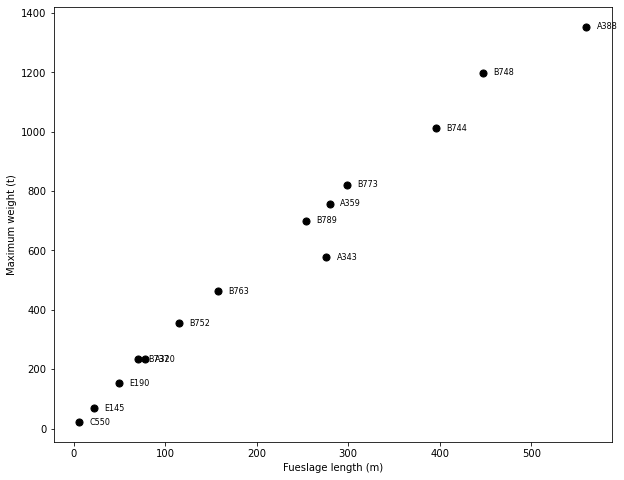

<IPython.core.display.Javascript object>

In [7]:
fig, ax = plt.subplots(1)
plotdata(ax)
plt.show()

# Linear model

Let us represent these weight and thurst pairs (2D points) as follows:

$$(x_0, y_0), (x_1, y_1), \cdots ,(x_N, y_N) $$

We want to fomulate a linear model to discribe the relateionshop between $x$ and $y$. The linear model can be express as:

$$y = \beta_0 + \beta_1 x$$

For a linear function, $\beta_0$ is the intercept, and $\beta_1$ is the slope. These are two parameters that we want to estimate.

## Some guesses

First, let us chose a few sets of $\beta_0$ and $\beta_1$:


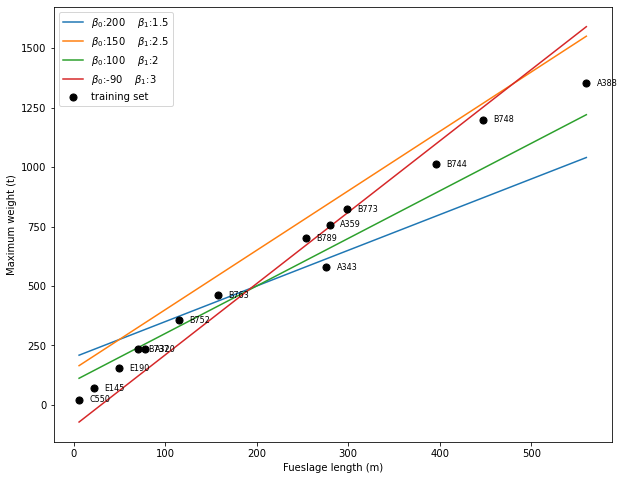

<IPython.core.display.Javascript object>

In [8]:
guesses = [(200, 1.5), (150, 2.5), (100, 2), (-90, 3)]

fig, ax = plt.subplots(1)
plotdata(ax)
for i, (b0, b1) in enumerate(guesses):
    plotmodel(ax, b0, b1, x_train, y_train, color=colors[i])
plt.show()

# Linear regression



The linear regression problem is to find the best pair of $\beta_0$ and $\beta_1$ that can "fit" the data the "best". 

Our first challenge: **defined what is the "best"**

---

Based on the linear model, we can also express the relation between $x_i$ and $y_i$ as folows:

$$y_i = \hat y_i + \epsilon_i $$


$\epsilon$ is the error term introduced to repsent the different between the estimated value $\hat y_i$ and data $y_i$.

Now we have:
$$y_i = \beta_0 + \beta_1 x_i + \epsilon_i$$



## Errors with examples

Let's use two of the guesses from earlier example to compare the error term $\epsilon$.

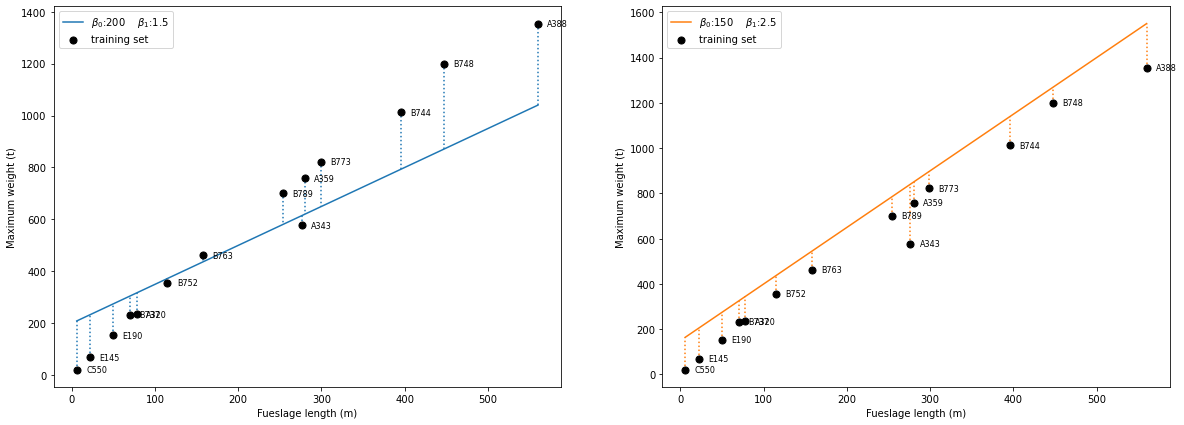

<IPython.core.display.Javascript object>

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
for i, (b0, b1) in enumerate(guesses[0:2]):
    plotdata(ax[i])
    plotmodel(ax[i], b0, b1, x_train, y_train, color=colors[i], err=True)
plt.show()

We can already see the second guess is better than the first, because the errors are smaller in general.

## Residual Sum of Squares (RSS)

$$
RSS = \sum_{i=1}^N \epsilon_i^2 
$$

Our goal is to find the best pair of $\hat\beta_0$ and $\hat\beta_1$, so that the combined squared error from all data point is minumum. As an optimization problem, we are going to use this as our cost function $Q$:

$$
\begin{align}
Q(\beta_0, \beta_1) &= \sum_{i=1}^N \epsilon_i^2 \\
&= \sum_{i=1}^N \left[ y_i - (\beta_0 + \beta_1 x_i) \right]^2
\end{align}
$$

## Let us see how can we visualize the RSS:

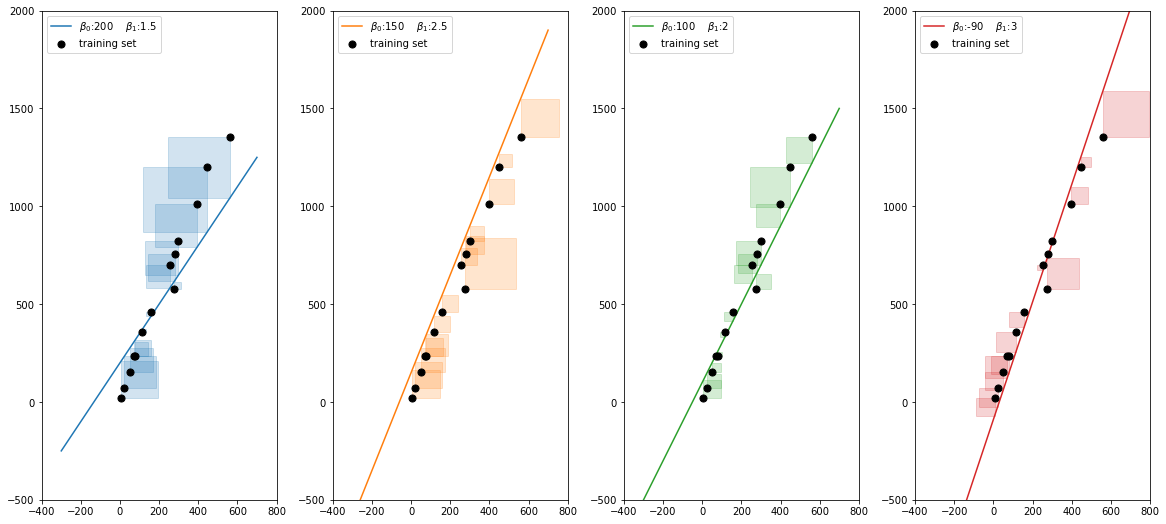

<IPython.core.display.Javascript object>

In [10]:
fig, ax = plt.subplots(1, 4, figsize=(20, 9))

for i, (b0, b1) in enumerate(guesses):
    plotdata(ax[i], text=False, label=False)
    plotmodel(ax[i], b0, b1, x_train, y_train, rss=True, color=colors[i])

plt.show()

Essentially, RSS is the sum of all the squre areas shown in above figures.

## Minimize RSS

Mathmatically, if we minimize the RSS: 

$$
\underset{\beta_0, \beta_1}{\operatorname{argmin}} \left( \sum_{i=1}^N \left[ y_i - (\beta_0 + \beta_1 x_i) \right]^2 \right)
$$

the closed-form solution is:

$$
\begin{align}
\hat\beta_0 &= \frac{\sum y_i}{N} - \hat\beta_1 \frac{\sum x_i}{N} \\
\hat\beta_1 &= \frac{\sum x_i y_i - \frac{1}{N} \sum x_i \sum y_i}{\sum x_i^2 - \frac{1}{N} \left(\sum x_i\right)^2}
\end{align}
$$

This solution is also called: **Least-Squares Solution**

## Calculate optimal $\beta_0$ and $\beta_1$ with our data

Recal closed-form solution:

$$
\begin{align}
\hat\beta_0 &= \frac{\sum y_i}{N} - \hat\beta_1 \frac{\sum x_i}{N} \\
\hat\beta_1 &= \frac{\sum x_i y_i - \frac{1}{N} \sum x_i \sum y_i}{\sum x_i^2 - \frac{1}{N} \left(\sum x_i\right)^2}
\end{align}
$$

In [11]:
n = len(x_train)
sum_y = np.sum(y_train)
sum_x = np.sum(x_train)
sum_xy = np.sum(x_train * y_train)
sum_x2 = np.sum(x_train ** 2)

b1_hat = (sum_xy - sum_x * sum_y / n) / (sum_x2 - sum_x ** 2 / n)
b0_hat = sum_y / n - b1_hat * sum_x / n

print("Optimal intecept and slope are:", b0_hat, "and", b1_hat)

Optimal intecept and slope are: 42.17743676528653 and 2.445870436826964


<IPython.core.display.Javascript object>

## Now we can visualize the best fit linear model

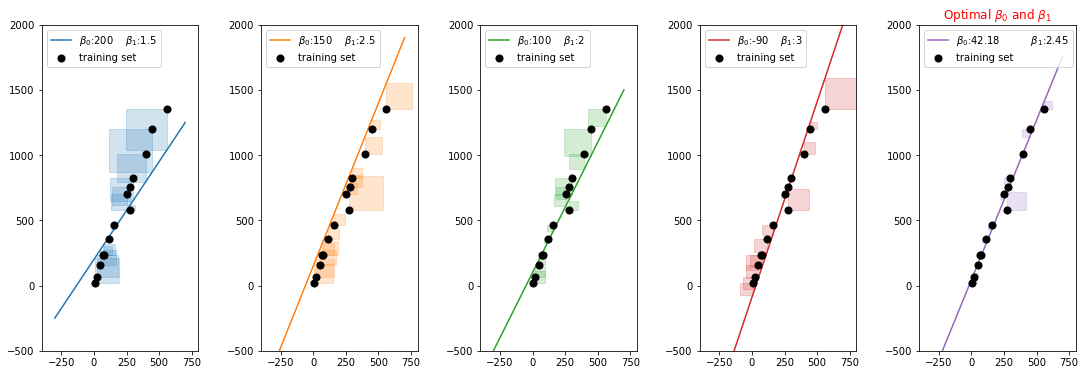

<IPython.core.display.Javascript object>

In [12]:
guesses_ = guesses + [(round(b0_hat, 2), round(b1_hat, 2))]
fig, ax = plt.subplots(1, 5, figsize=(19, 6))
for i, (b0, b1) in enumerate(guesses_):
    plotdata(ax[i], text=False, label=False)
    plotmodel(ax[i], b0, b1, x_train, y_train, rss=True, color=colors[i])
    if i == 4:
        ax[i].set_title("Optimal $\\beta_0$ and $\\beta_1$", color="r")
plt.show()

Note: The last plot of least squre solution shows the best fit of the all possible lines.

## How good is the fit? 

Now we can introduce two error metrics to tell how well a model fits to the data.

**Mean Squared Error (MSE)**: equivalent to the average of RSS:

$$
\begin{align}
\mathrm{MSE} &= \frac{1}{N} RSS \\
              &= \frac{1}{N} \sum_{i=0}^N \left[ y_i - (\hat\beta_0 + \hat\beta_1 x_i) \right]^2
\end{align}
$$


**Root Mean Squared Error (RMSE)**: equivalent to the square root of MSE (or average RSS).

$$
\begin{align}
\mathrm{RMSE} &= \sqrt {MSE} = \sqrt {\frac{1}{N} RSS} \\
              &= \sqrt {\frac{1}{N} \sum_{i=0}^N \left[ y_i - (\hat\beta_0 + \hat\beta_1 x_i) \right]^2}
\end{align}
$$

When evaluate MSE and RMSE with testing data, **the smaller the better**. 

The advantage of RMSE over MSE is that the unit of RMSE is the same as $y$.

Based on test data and $\hat \beta_0$ and $\hat \beta_1$, we can calculate MSE and RMSE as:

In [13]:
def mse(x, y, b0, b1):
    n = len(x)
    return 1 / n * np.sum((y - (b0 + b1 * x)) ** 2)


def rmse(x, y, b0, b1):
    n = len(x)
    return np.sqrt(1 / n * np.sum((y - (b0 + b1 * x)) ** 2))

<IPython.core.display.Javascript object>

MSE = 2047.41 (kN^2)
RMSE = 45.25 (kN)


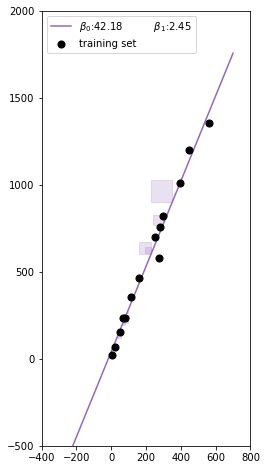

<IPython.core.display.Javascript object>

In [14]:
MSE = mse(x_test, y_test, b0_hat, b1_hat)
RMSE = rmse(x_test, y_test, b0_hat, b1_hat)

print("MSE = {} (kN^2)".format(MSE.round(2)))
print("RMSE = {} (kN)".format(RMSE.round(2)))

fig, ax = plt.subplots(1)
plotdata(ax, text=False, label=False)
plotmodel(ax, b0, b1, x_test, y_test, rss=True, color=colors[4])
plt.show()

# Using Numpy to perform simple linear regression

We can also use Numpy to perform the previous regression.

In [15]:
model = np.polyfit(x_train, y_train, deg=1)

print("intercept:", model[1].round(2))
print("slope:", model[0].round(2))

intercept: 42.18
slope: 2.45


<IPython.core.display.Javascript object>

# Using Scikit-Learn to perform simple linear regression

We can also use Scikit-Learn to perform the previous regression in just one line.

(Note: the input parameter $X$ need to be a 2D array)

In [16]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression().fit(x_train.reshape(-1, 1), y_train)

print("intercept:", lr.intercept_.round(2))
print("slope:", lr.coef_[0].round(2))

intercept: 42.18
slope: 2.45


<IPython.core.display.Javascript object>

MSE and RMSE can also be calculated using Scikit-Learn functions:

In [17]:
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(y_test, lr.predict(x_test.reshape(-1, 1)))
print("MSE:", MSE.round(2))
print("RMSE:", np.sqrt(MSE).round(2))

MSE: 2047.41
RMSE: 45.25


<IPython.core.display.Javascript object>